In [1]:
import numpy as np
import matplotlib.pyplot as plt

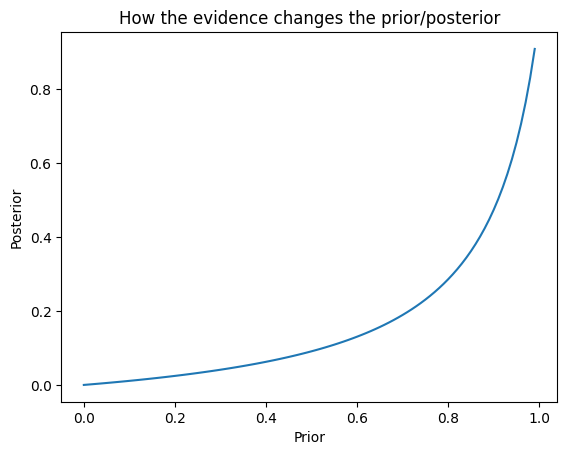

In [2]:
# Hand-solved solution for the murder problem
prior = np.arange(0,1,0.01)
plt.plot(prior, prior / (10 - 9*prior))
plt.xlabel("Prior")
plt.ylabel("Posterior")
plt.title("How the evidence changes the prior/posterior")
plt.show()

# A  more general example

Here we build a more general example, where we have two alternative hypotheses $H_0, H_1$ that are mutually exclusive so that
$P(H_0) = 1 - P(H_1)$

We also conduct a test, which can be true or false, so that $P(T | H) = 1 - P(F | H)$ for either hypothesis $H$.
However, the code is general enough for it to allow $n$ possible hypotheses and $k$ possible different outcomes of the test. Right now we instantiate it with $n=k=2$.

In that case, our hypothesis test has a very special structure, and we only need to specify three parameters for the problem.

1. The prior $P(H_1)$, since $P(H_0) = 1 - P(H_1)$.
2. The true positive rate $P(T | H_1)$, also called the *sensitivity* of the test.
3. The true negative rate $P(F | H_0)$, also called the *specificity* of the test.
 

In [12]:
# 2 alternatives, but could be more
# Here prior[i] is P(H_i)
n_alternatives = 2
prior = np.ones(n_alternatives)/n_alternatives # here the prior probability
prior

array([0.5, 0.5])

In [4]:
# no data involved! subjective belief
prior[0] # the probability of no-covid
prior[1] # the probability of covid

0.5

In [13]:
# Here we build the likelihood function as a 2x2 matrix
# likelihood[data][hypothesis] 
# gives us the probability of the data, given the hypothesis, i.e. 
# P(data | hypothesis)
# In the example above, we use data = 1 for a positive test and data = 0 for a negative one

n_outcomes = 2
likelihood = np.zeros([n_outcomes, n_alternatives])
TNR = 0.9 # true negative rate P(F | H_0)
TPR = 0.8 # true positive rate P(T | H_1)
likelihood[0][0] = TNR # negative test, no covid P(F | H_0)
likelihood[1][0] = 1 - TNR # positive test, no covid P(T | H_0) 
likelihood[0][1] = 1 - TPR # negative test, covid P(F | H_1)
likelihood[1][1] = TPR # positive test, covid P(T | H_1)
likelihood


array([[0.9, 0.2],
       [0.1, 0.8]])

In [6]:
# Here we perform the calculation
# P(H | D) = P(D | H) P(H) / P(D)
def posterior(prior, likelihood, data):
    n_alternatives = len(prior)
    evidence = np.zeros(n_alternatives)
    # First we calculate the factors P(D | H) P(H)
    for hypothesis in range(n_alternatives):
        evidence[hypothesis] = likelihood[data][hypothesis] * prior[hypothesis] # P(D|H) P(H)
    # Since P(D) = \sum_i P(D | H_i) P_i(H_i) 
    # We get P(H | D) = P(D | H) P(H) / P(D)
    posterior = evidence / np.sum(evidence)
    return posterior
    # The last line could be written with a loop as well
    #for hypothesis in range(n_alternatives):
    #    posterior[hypothesis] = evidence[hypothesis] / np.sum(evidence)

In [7]:
posterior(prior, likelihood, 1)

array([0.11111111, 0.88888889])

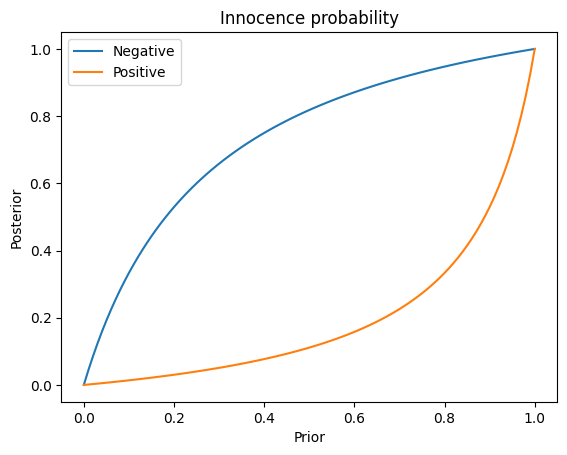

In [16]:
# Let us now make a plot for this evidence.
# (Explanation below)
Q = np.arange(0,1.01,0.01)
post_pos = np.zeros(len(Q))
post_neg = np.zeros(len(Q))

for k in range(len(Q)):
    prior[0] = Q[k]
    prior[1] = 1 - Q[k]
    post_pos[k] = posterior(prior, likelihood, 1)[0]
    post_neg[k] = posterior(prior, likelihood, 0)[0]

plt.plot(Q, post_neg)
plt.plot(Q, post_pos)
plt.legend(["Negative", "Positive"])
plt.xlabel("Prior")
plt.ylabel("Posterior")
plt.title("Innocence probability")
plt.show()

# The strength of evidence

The plot shows the effect of the evidence (negative or positive results) on changing the prior to a new posterior value. If the evidence is weak, then the lines are close to the diagonal. The stronger the evidence is, the more the lines bend away from the diagonal. Change the values for true positive and true negative rates to see the effect.

In all cases, however, if our prior is 0 or 1, then the posterior remains 0 or 1. No amount of evidence can change our opinion.


# The Bernoulli model

In the Bernoulli model of a coin toss, we say $x \in \{0, 1\}$ is Bernoulli-distributed with parameter $\beta$ if the probability of heads is $\beta$.
We can write this succintly as 
$$P_\beta(x) = \beta^{x} (1 - \beta)^{1 - x}.$$
For a /sequence/ of coin tosses $x_1, \ldots, x_t, \ldots, x_T$, we assume that they are independent so that
$$P_\beta(x_1, \ldots, x_T) = P_\beta(x_1) \times \cdot \times P_\beta(x_T) = \prod_{t=1}^T P_\beta(x_T)$$

## Maximum likelihood estimate
A simple estimate for $\beta$, given a sequence of coin tosses is the rate of heads, i.e. 
$$\hat{\beta} = \sum_{t=1} x_t / T$$.

This coincides with the *maximum likelihood* estimate, i.e. 
$$\hat{\beta} = \arg\max_\beta \prod_{t=1}^T P_\beta(x_T).$$

You can show this by taking the logarithm of the likelihood, differentiating and solving for zero.

However, this estimate is a bit weird. If we have a single coin toss, which comes heads, our estimate is then that beta is 1. This is clearly absurd, because even a completely fair coin  with $\beta = 1/2$, will have to come either heads or tails. So, after one coin toss, our estimate will either be 0 or 1, so very far from the true value of 1/2. What can we do about this?

## Maximum a posteriori estimate

We can use the idea of priors to temper the likelihood. We can add a factor $\phi(\beta)$ that places more weight on $\beta$ around 0.5. A common choice is to have
$$\phi(\beta) = \beta^{\alpha_1} (1 - \beta)^{\alpha_0}$$, which for higher $\alpha_1$ makes your prior closer to 1 and for higher $\alpha_0$ makes your prior closer to $0$. You should experiment with this to see how the prior changes for different values of $\alpha$ parameters.

The maximum a posteriori estimate is 
$$\hat{\beta} = \arg\max_\beta \prod_{t=1}^T P_\beta(x_T) \phi(\beta).$$
and we can show that this is actually equal to 
$$\hat{\beta} = \sum_{t=1} (x_t + \alpha_1) / (T + \alpha_0 + \alpha_1)$$.

So, the prior effectively adds fake coin tosses to the setting.

## Bayesian estimate

The Bayesian estimate builds on the maximum a posteriori estimate. However, we never select a single value of $\beta$. We have to calculate the complete posterior distribution.
This is left as an exercise for you at the end of the notebook. While there is an algebraic solution, for the exercise you should just adapt the code from the previous example and calculate the posterior for a range of betas.



In [18]:
# beta is the probability of heads
def ber_likelihood(beta, x):
    return np.power(beta, np.sum(x))*np.power(1 - beta, np.sum(1 - x))

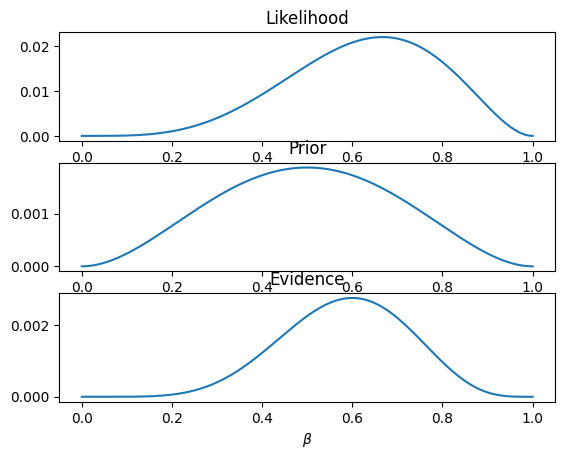

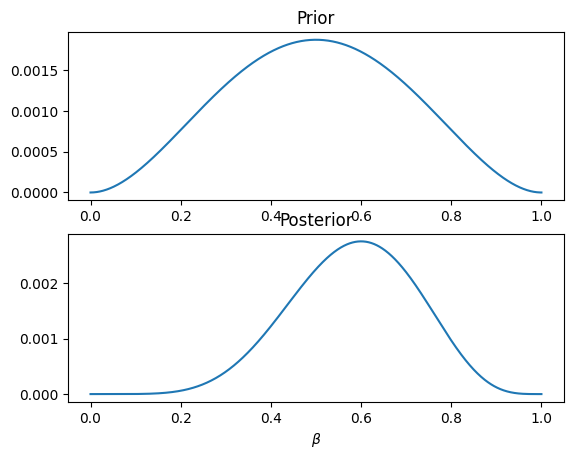

In [51]:
x = np.array([1,0,0,1,1,1])
#x = np.array([1]) #this is our data
beta=np.arange(0,1.001,0.001) # this is our range of possible betas
prior = np.power(beta, 2)*np.power(1 - beta, 2)
prior /= np.sum(prior) # to make it to scale 
evidence = prior*ber_likelihood(beta, x)
evidence /= np.sum(evidence) # this is the solution of the exercise
plt.subplot(3,1,1)
plt.plot(beta, ber_likelihood(beta, x))
plt.xlabel("$\\beta$")
plt.title("Likelihood")
plt.subplot(3,1,2)
plt.plot(beta, prior)
plt.xlabel("$\\beta$")
plt.title("Prior")
plt.subplot(3,1,3)
plt.plot(beta, evidence)
plt.xlabel("$\\beta$")
plt.title("Evidence")
plt.show()
## Add a plot for the posterior here
plt.subplot(2,1,1)
plt.plot(beta, prior)
posterior = bernoulli_posterior(x, beta, prior)
plt.title("Prior")

plt.subplot(2,1,2)
plt.plot(beta, posterior)
plt.title("Posterior")
plt.xlabel("$\\beta$")
plt.show()

# Exercise

Add some code to calculate the likelihood and posterior for a series of coin tosses. Your code should work for any number of coin tosses as input. Then add the plot of the posterior


In [40]:
# Inputs
# data: an array of binary numbers
# beta: an array of real numbers in [0,1], each specifying a possible value of beta
# prior: an array of real numbers summing to 1, each specifying a probability for each value of beta
# Returns
# posterior: the posterior distribution of betas
def bernoulli_posterior(data, betas, prior):
    n_alternatives = len(prior)
    likelihood = ber_likelihood(betas, data)
    evidence = prior*likelihood
    posterior = evidence / np.sum(evidence)
    return posterior

In [41]:
data = np.array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1])
betas=np.arange(0,1.001,0.001)
prior = np.power(betas, 2)*np.power(1 - betas, 2)
prior /= np.sum(prior)
posterior = bernoulli_posterior(data, beta, prior)

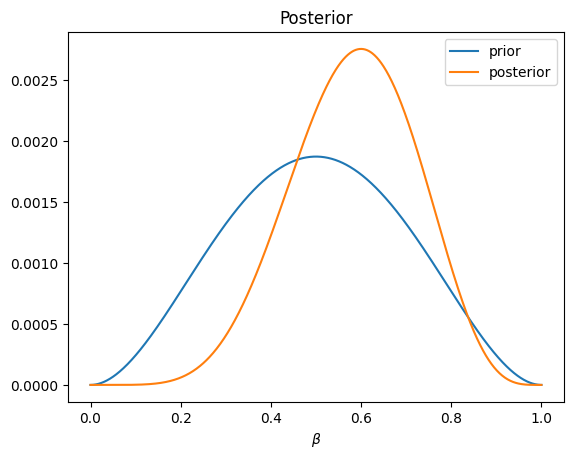

In [53]:
plt.plot(betas, prior)
plt.plot(betas, posterior)
plt.legend(["prior", "posterior"])
plt.title("Posterior")
plt.xlabel("$\\beta$")

plt.show()